<a href="https://colab.research.google.com/github/svetaU/Attention/blob/main/attnClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script implements self-attention model for classification. It borrows some code from https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html

# Imports

In [15]:
import sys, subprocess
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  print("You are in Google Colab environment!")
  from google.colab import drive
  drive.mount('/content/drive')
else:
  print("This notebook is best run in Google Colab.")

You are in Google Colab environment!
Mounted at /content/drive


In [16]:
import numpy as np
import pandas as pd
import math
%tensorflow_version 2.10
try:
  import einops
except ModuleNotFoundError: 
  !pip install --quiet einops
from einops import rearrange
from einops import repeat
import torch
from torch import nn
import torch.nn.functional as F
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: 
    !pip install --quiet pytorch-lightning>=1.7
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.utils.data as data
import torch.optim as optim
pl.seed_everything(42)
import os
CHECKPOINT_PATH = "/content/drive/My Drive/Colab Notebooks/SA-prototype/"
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
device = torch.device("cpu")

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Plotting imports

In [17]:
## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg', 'pdf') # For export
try:
  import matplotlib_inline
except ModuleNotFoundError: 
  !pip install --quiet matplotlib_inline
  import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

# Attention module

In [18]:
class NiptMultiHeadSelfAttention(nn.Module):
    
    def __init__(self, embed_dim, heads=2):
        super().__init__()
        self.embed_dim=embed_dim
        self.heads=heads
        self.dim_head = (int(self.embed_dim / self.heads)) 
        _dim = self.dim_head * self.heads
        self.to_qvk = nn.Linear(self.embed_dim, _dim * 3, bias=False)
        self.last_linear = nn.Linear( _dim, self.embed_dim, bias=False)
        self.scale_factor = self.dim_head ** -0.5
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.xavier_uniform_(self.to_qvk.weight)
        nn.init.xavier_uniform_(self.last_linear.weight)
        
    def forward(self, x, mask=None, return_attention=False):
        assert x.dim() == 3
        qkv = self.to_qvk(x)
        q, k, v = tuple(rearrange(qkv, 'b t (d k h) -> k b h t d ', k=3, h=self.heads))
        scaled_dot_prod = torch.einsum('b h i d , b h j d -> b h i j', q, k) * self.scale_factor
        if mask is not None:
            assert mask.shape == scaled_dot_prod.shape[2:]
            scaled_dot_prod = scaled_dot_prod.masked_fill(mask, -np.inf)

        attention = torch.softmax(scaled_dot_prod, dim=-1)
        values = torch.einsum('b h i j , b h j d -> b h i d', attention, v)
        values = rearrange(values, 'b h t d -> b t (h d)')
        output = self.last_linear(values)
        if return_attention:
            return output, attention
        else:
            return output

# Encoder

In [19]:
class NiptEncoderBlock(nn.Module):
    
    def __init__(self,embed_dim,num_heads = 2,dim_linear_block=1024, dropout = 0.0):
        super().__init__()
        self.embed_dim=embed_dim
        self.num_heads=num_heads
        self.dim_linear_block=dim_linear_block
        self.dropout=dropout
        self.attn_layer = NiptMultiHeadSelfAttention(embed_dim=self.embed_dim, 
                                                     heads=self.num_heads)
        self.norm1 = nn.LayerNorm(self.embed_dim)        
        self.norm2 = nn.LayerNorm(self.embed_dim)
        self.drop = nn.Dropout(self.dropout)
        self.linear_net = nn.Sequential(
            nn.Linear(self.embed_dim, self.dim_linear_block),
            nn.Dropout(self.dropout),
            nn.ReLU(inplace=True),
            nn.Linear(self.dim_linear_block, self.embed_dim)
        )
        
    def forward(self, x, mask=None):
        y = self.norm1(self.drop(self.attn_layer(x, mask)) + x)
        return self.norm2(self.linear_net(y) + y)


In [20]:
class NiptAttentionEncoder(nn.Module):
    
    def __init__(self, embed_dim,num_heads,dim_linear_block,dropout,num_layers=6):
        super().__init__()
        self.embed_dim=embed_dim
        self.num_heads=num_heads
        self.dim_linear_block=dim_linear_block
        self.dropout=dropout
        self.num_layers=num_layers
        self.layers = nn.ModuleList([NiptEncoderBlock(embed_dim=self.embed_dim,
                                    num_heads=self.num_heads,
                                    dim_linear_block=self.dim_linear_block, 
                                    dropout=self.dropout) for _ in range(self.num_layers)])
        
    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x
    
    def get_attention(self,x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.attn_layer(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x, mask=mask)
        return attention_maps

# Classifier module

In [21]:
class NiptClassifier(pl.LightningModule):
    def __init__(self, embed_dim, num_tokens, num_heads, 
                 num_layers, model_dim,lr, dropout=0.0, input_dropout=0.0):
        super().__init__()
        self.save_hyperparameters()
        self._create_model()
        
    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.embed_dim, self.hparams.model_dim)
        )
        # Transformer
        self.transformer = NiptAttentionEncoder(
                                              embed_dim=self.hparams.model_dim,
                                              num_layers=self.hparams.num_layers,
                                              dim_linear_block=2*self.hparams.embed_dim,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        # Output classifier per sequence elment
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.hparams.model_dim, 1),
            nn.ReLU(inplace=True)
        )
        self.prob = nn.Sequential(
            nn.Linear(self.hparams.num_tokens,1)
        )
        
    def forward(self, x, mask=None, add_positional_encoding=False):
        x = self.input_net(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        x = rearrange(x, 'b c h  -> b (c h)')
        x = self.prob(x)
        return x
    
    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=False):
        x = self.input_net(x)
        attention_maps = self.transformer.get_attention(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)
        #scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        #return [optimizer], [{'scheduler': scheduler,'interval': 'step'}]
        return optimizer

    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError

In [22]:
class AdversePredictor(NiptClassifier):

    def _calculate_loss(self, batch, mode="train"):
        # Fetch data (labels are floats 0. or 1.)
        inp_data, labels = batch

        # Perform prediction and calculate loss and accuracy
        preds = self.forward(inp_data, add_positional_encoding=False)
        loss = F.cross_entropy(preds.view(-1), labels.view(-1))
        #loss = F.cross_entropy(preds, labels)
        acc = ((preds.view(-1) > 0.) == (labels > 0.)).float().mean()

        # Logging
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

# Auxiliary functions

In [23]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

In [24]:
class fakeDataset(data.Dataset):
    def __init__(self, num_seqs, num_tokens, token_size, class_fraction):
        super().__init__()
        self.num_seqs = num_seqs
        self.num_tokens = num_tokens
        self.token_size = token_size
        self.num_elements = int(num_seqs*class_fraction)
        self._generate_data()
        
    def _generate_data(self):
        
        assert self.num_tokens > 2
        self.labels = torch.zeros(self.num_seqs,dtype=torch.float)
        mean = repeat(torch.arange(0.,self.num_tokens).unsqueeze(-1).expand(-1,self.token_size), 
                      't i -> s t i',s=self.num_seqs) #each token has the mean of its index
        self.data = torch.normal(mean=mean)
        class_inds = torch.randperm(self.num_seqs)[:self.num_elements]
        self.labels[class_inds] = 1.
        self.data[class_inds,0,:] = torch.empty(self.token_size).normal_(mean=4.)
        self.data[class_inds,2,:] = torch.empty(self.token_size).normal_(mean=10.)
                
        
    def __len__(self):
        return self.num_seqs
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Train and Test

In [49]:
train_ds = fakeDataset(600,9,64,0.5)
train_ds_loader = data.DataLoader(train_ds, batch_size=16, shuffle=True,  drop_last=True)
val_ds = fakeDataset(100,9,64,0.5)
val_ds_loader = data.DataLoader(val_ds, batch_size=16, shuffle=False,  drop_last=False)
test_ds = fakeDataset(300,9,64,0.5)
test_ds_loader = data.DataLoader(test_ds, batch_size=16, shuffle=False,  drop_last=False)

In [44]:
def train_nipt(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "testTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=100,
                         gradient_clip_val=2)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "testTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = AdversePredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = AdversePredictor(**kwargs)
        trainer.fit(model, train_ds_loader, val_ds_loader)
        model = AdversePredictor.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    train_result = trainer.test(model, train_ds_loader, verbose=False)
    val_result = trainer.test(model, val_ds_loader, verbose=False)
    test_result = trainer.test(model, test_ds_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"], "train_acc": train_result[0]["test_acc"]}

    model = model.to(device)
    return model, result

In [50]:
nipt_model, nipt_result = train_nipt(embed_dim=64,
                                     model_dim=128,
                                     num_tokens = 9,
                                     num_heads=4,
                                     num_layers=4,
                                     dropout=0.1,
                                     input_dropout=0.1,
                                     lr=5e-4)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type                 | Params
-----------------------------------------------------
0 | input_net   | Sequential           | 8.3 K 
1 | transformer | NiptAttentionEncoder | 396 K 
2 | output_net  | Sequential           | 16.9 K
3 | prob        | Sequential           | 10    
-----------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.686     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

In [51]:
print(f"Train accuracy: {(100.0*nipt_result['train_acc']):4.2f}%")
print(f"Val accuracy:   {(100.0*nipt_result['val_acc']):4.2f}%")
print(f"Test accuracy:  {(100.0*nipt_result['test_acc']):4.2f}%")

Train accuracy: 53.21%
Val accuracy:   66.00%
Test accuracy:  67.33%


In [52]:
inp_data, labels = next(iter(test_ds_loader))
inp_data = inp_data.to(device)
nipt_model.eval()
preds = nipt_model.forward(inp_data, add_positional_encoding=False)
attention_maps = nipt_model.get_attention_maps(inp_data, add_positional_encoding=False)

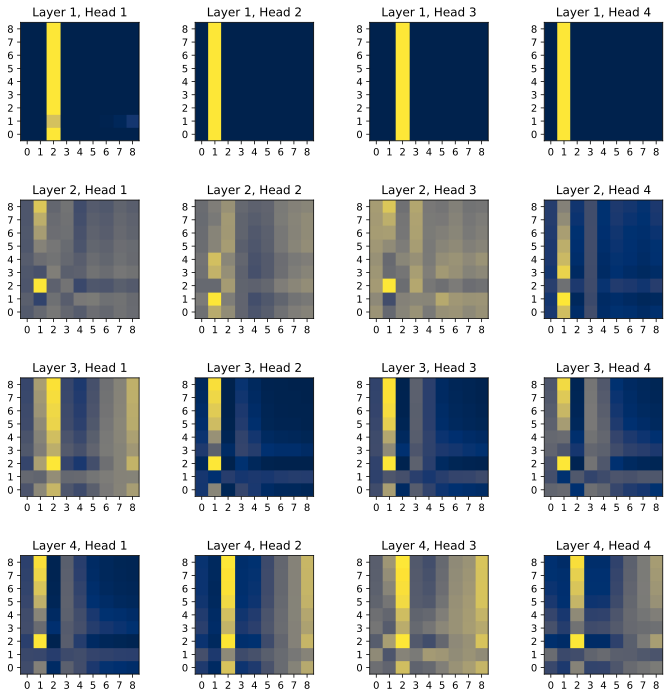

In [56]:
plot_attention_maps(input_data=None,attn_maps=attention_maps,idx=15)

In [54]:
preds

tensor([[ 0.1639],
        [-0.0791],
        [-0.0791],
        [-0.0791],
        [ 0.1103],
        [-8.9891],
        [ 0.1141],
        [-0.0318],
        [-0.0791],
        [-8.9866],
        [ 0.0612],
        [-8.9428],
        [ 0.1934],
        [-8.5902],
        [-8.9902],
        [-0.0791]], grad_fn=<AddmmBackward0>)

In [55]:
labels

tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1.])